# First attempt at a solution, problem statement below

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
<div>
<img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png", width="200"/>
</div>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from spellchecker import SpellChecker
import spacy
import tqdm
from sklearn.model_selection import train_test_split

import nltk.corpus
#nltk.download('stopwords')
#from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
nltk.download('punkt')


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model



%matplotlib inline
pd.set_option('max.column', 100)
pd.set_option('max.row', 100)
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 15,8
pd.set_option('display.max_colwidth', None)
sns.set()
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## import data

In [3]:
df = pd.read_csv(r'../data/train.csv')
test = pd.read_csv(r'../data/test.csv')
df.shape, test.shape

((7613, 5), (3263, 4))

In [4]:
df.isnull().sum() / len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

<AxesSubplot:>

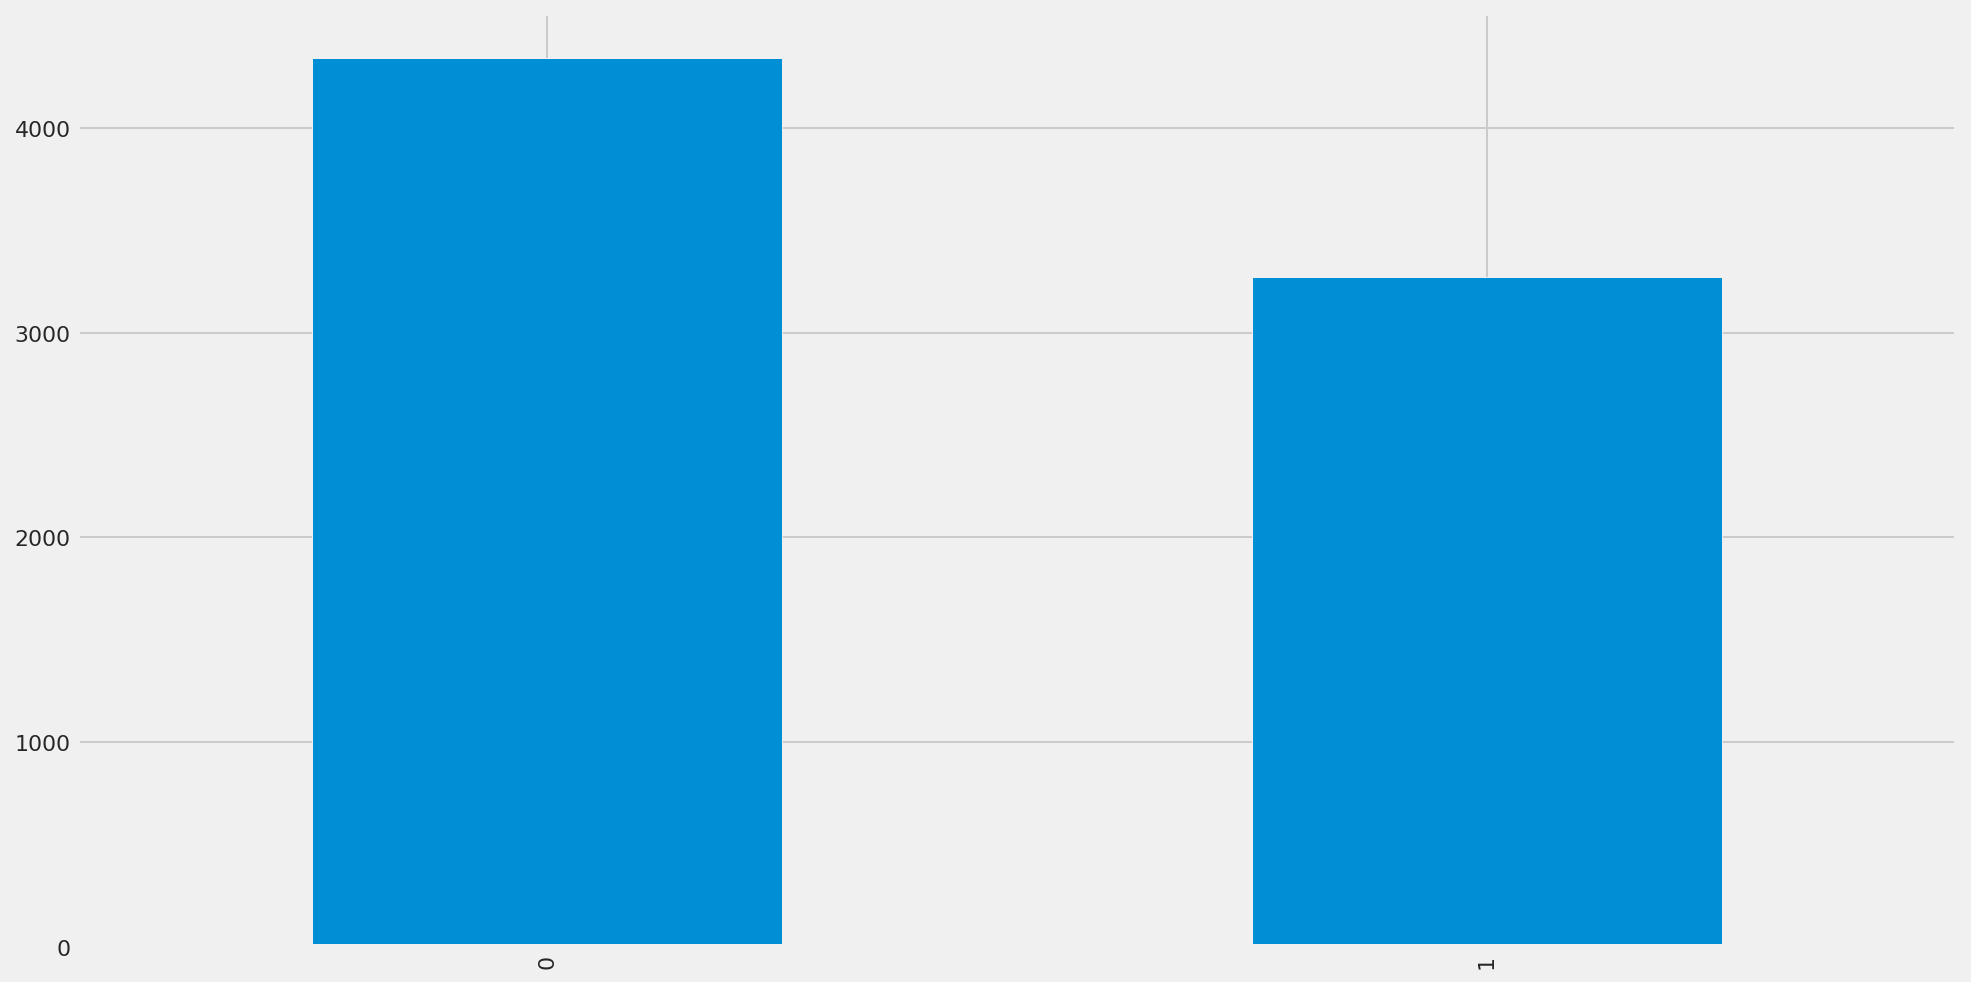

In [5]:
df['target'].value_counts().plot(kind='bar')

In [6]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

## Data Cleansing

In [7]:
# Remove URLs

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

In [8]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [9]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emoji(x))

In [10]:
## created a piece to spell correct, but it takes way too long to do


#%%time 
#
#spell = SpellChecker(tokenizer=True)
#
#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = spell.unknown(text.split())
#    for word in text.split():
#        if word in misspelled_words:
#            corrected_text.append(spell.correction(word))
#        else:
#            corrected_text.append(word)
#    return " ".join(corrected_text)
#
#
#df['text'][:50].apply(lambda x : correct_spellings(x))

## Create Corpus 

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
%%time
df['tokenized'] = df['text'].apply(nlp)

CPU times: user 46 s, sys: 90.8 ms, total: 46.1 s
Wall time: 46.2 s


In [14]:
# should split up, removes stop words, punctuation, useless words and lemmatizes

df['tokenized_clean'] = df['tokenized'].apply(lambda doc: ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct
                                                                   and not token.pos_=='X']))

In [15]:
df['tokenized_clean'].head()

0                                               deed reason earthquake allah forgive
1                                              forest fire near la ronge sask canada
2    resident ask shelter place notify officer evacuation shelter place order expect
3                         13,000 people receive wildfire evacuation order california
4                              got send photo ruby alaska smoke wildfire pour school
Name: tokenized_clean, dtype: object

In [20]:
%%time
df['sent_vectors'] = df['tokenized'].apply(lambda doc: np.mean([token.vector for token in doc]))

CPU times: user 383 ms, sys: 7.97 ms, total: 391 ms
Wall time: 394 ms


In [23]:
df.head(2)

,id,keyword,location,text,target,tokenized,tokenized_clean,sent_vectors
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",deed reason earthquake allah forgive,-0.00568
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near la ronge sask canada,-0.02064


In [25]:
df['char_len'] = df['tokenized_clean'].apply(lambda x: len(x))
df['word_len'] = df['tokenized_clean'].apply(lambda x: len(x.split()))

No handles with labels found to put in legend.


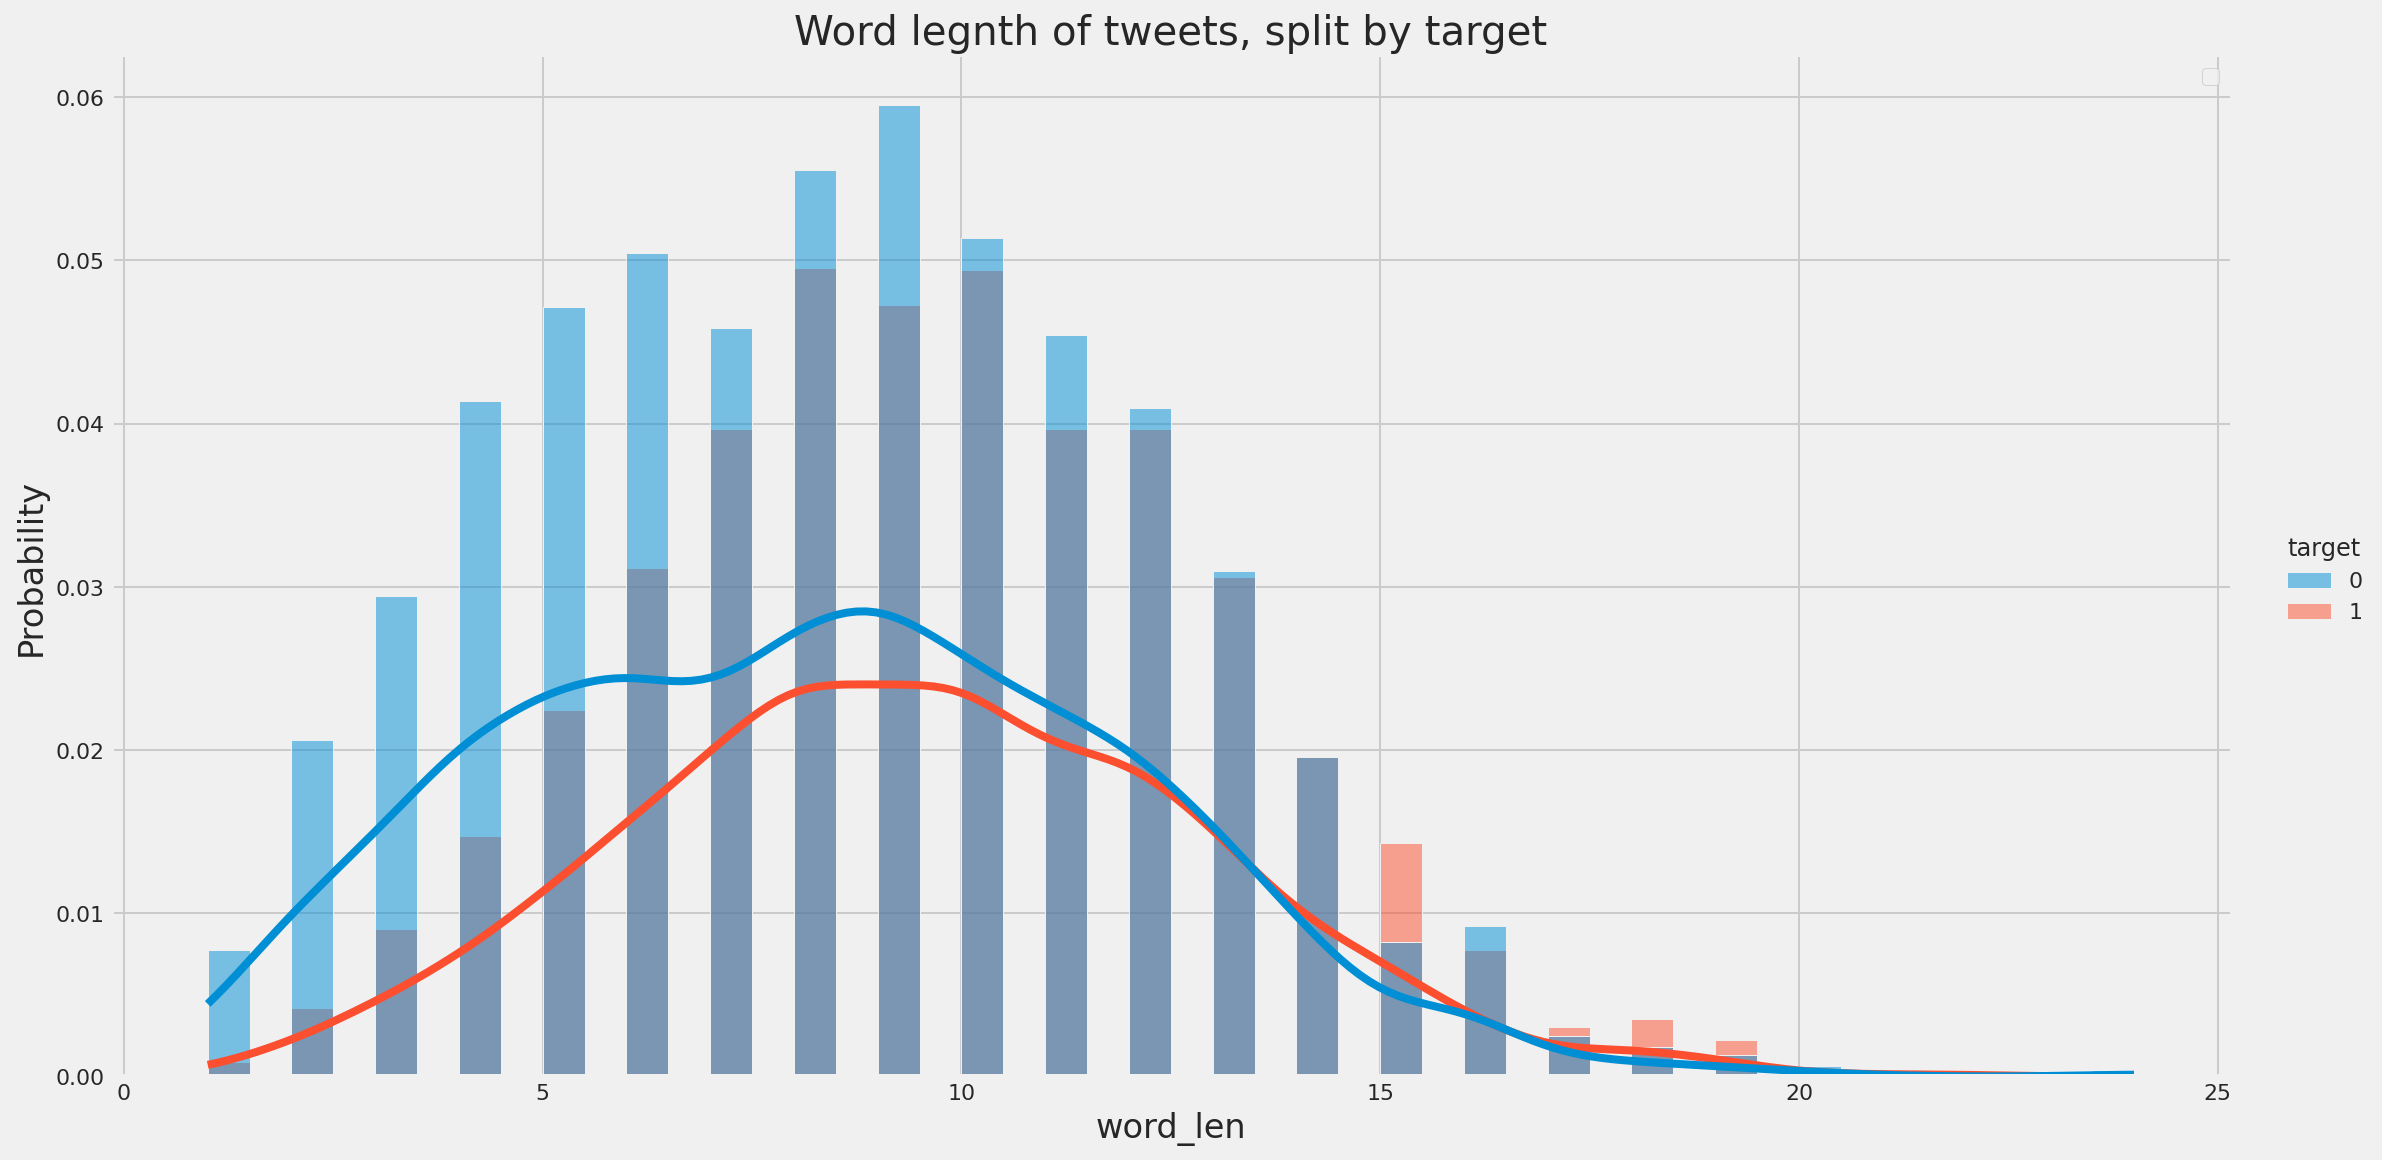

In [47]:
sns.displot(df, x='word_len', hue='target',stat='probability', kde=True, height=8, aspect=2)
plt.title('Word legnth of tweets, split by target')
plt.legend()

In [49]:
corpus = []
for text in df['tokenized_clean']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)
print(len(corpus))

7613


In [79]:
X = df['tokenized_clean']
y = df['tokenized_clean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5329,) (5329,)
(2284,) (2284,)


In [80]:
max_len = 32
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')

print(f'Number of unique words: {len(tokenizer.word_index)}')

Number of unique words: 15683


In [85]:
# Source: https://zenodo.org/record/3237458#.YVws_UbMK3J
# Original Source: https://github.com/stanfordnlp/GloVe

embedding = {}
with open("../data/input/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

print(f"Number of words in embedding file: {len(embedding)}")

In [93]:
embedding_matrix = np.zeros((len(corpus)+1, 100))
for i, word in tokenizer.index_word.items():
    if i < (len(corpus)+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [95]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5329, 32) (5329,)
(2284, 32) (2284,)


In [100]:
embedding_matrix.shape

(7614, 100)

## Modelling 

In [101]:
embedding_matrix.shape

(7614, 100)

In [108]:
model = Sequential()

model.add(Embedding(input_dim=len(corpus)+1, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=32, trainable=False))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           761400    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 841,901
Trainable params: 80,501
Non-trainable params: 761,400
_________________________________________________________________


In [117]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 4.4 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=4d33323fe783c14459d7f7f3a61300d07361acac89a7ac8fcb4c6c04d6eb1adf
  Stored in directory: /home/jovyan/.cache/pip/wheels/89/e5/de/6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus


In [124]:
!apt-get install graphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [123]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
